# Introducing Keras

Let's use Keras on the MNIST data set again, this time using a Convolutional Neural Network that's better suited for image processing. CNN's are less sensitive to where in the image the pattern is that we're looking for.

With a multi-layer perceptron, we achieved around 97% accuracy. Let's see if we can beat that.

As before we'll start by importing the stuff we need, including the new layer types we talked about:

In [100]:
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import (Dense, Conv1D, Flatten, Activation, BatchNormalization, Activation, Dropout)
from tensorflow.keras import Sequential, regularizers, optimizers
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as spio

We'll load up our raw data set exactly as before:

In [101]:
mat_files=spio.loadmat('Abemaciclib_Data_NIR_clean.mat')
SPEC_CAL = mat_files['SPEC_B_PLS_TRAINING']
Y_CAL = mat_files['Y_BC_PLS_TRAINING']
SPEC_TEST = mat_files['SPEC_VAL_B']
Y_TEST = mat_files['Y_VAL_B']
WL_AXIS=mat_files['WL_AXIS_B']
SPEC_CAL=SPEC_CAL[:,7:50];
SPEC_TEST=SPEC_TEST[:,7:50];
WL_AXIS=WL_AXIS[:,7:50].transpose();
SPEC_CAL = SPEC_CAL.reshape(SPEC_CAL.shape[0],SPEC_CAL.shape[1],1)
SPEC_TEST = SPEC_TEST.reshape(SPEC_TEST.shape[0],SPEC_TEST.shape[1],1)

print(SPEC_CAL.shape)
print(SPEC_TEST.shape)
WL_AXIS.shape

(1600, 43, 1)
(400, 43, 1)


(43, 1)

We need to shape the data differently then before. Since we're treating the data as 2D images of 28x28 pixels instead of a flattened stream of 784 pixels, we need to shape it accordingly. Depending on the data format Keras is set up for, this may be 1x28x28 or 28x28x1 (the "1" indicates a single color channel, as this is just grayscale. If we were dealing with color images, it would be 3 instead of 1 since we'd have red, green, and blue color channels)

As before we need to convert our train and test labels to be categorical in one-hot format:

As a sanity check let's print out one of the training images with its label:

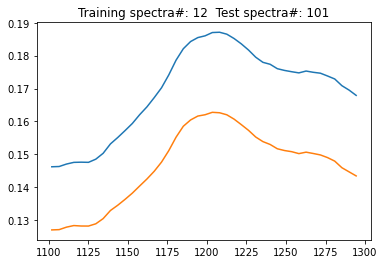

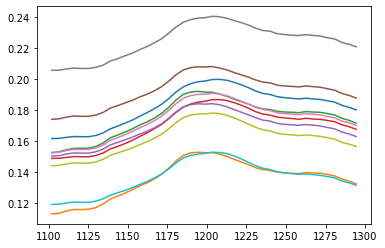

In [102]:
import matplotlib.pyplot as plt

def display_sample(num1,num2):
    #Print training and test spectra 
    fig, ax = plt.subplots()
    ax.plot(WL_AXIS,SPEC_CAL[num1,:])
    ax.plot(WL_AXIS,SPEC_TEST[num2,:])
    plt.title('Training spectra#: %d  Test spectra#: %d' % (num1, num2))
    plt.show()
    
display_sample(12,101)

temp=SPEC_CAL[0:800:80,:,:]
from pylab import *
#for r in range(conv1D_output.shape[2]):
for i in range(temp.shape[0]):
    #subplot(conv1D_output.shape[2],1,1)
    plt.plot(WL_AXIS,temp[i,:, :])  

Now for the meat of the problem. Setting up a convolutional neural network involves more layers. Not all of these are strictly necessary; you could run without pooling and dropout, but those extra steps help avoid overfitting and help things run faster.

We'll start with a 2D convolution of the image - it's set up to take 32 windows, or "filters", of each image, each filter being 3x3 in size.

We then run a second convolution on top of that with 64 3x3 windows - this topology is just what comes recommended within Keras's own examples. Again you want to re-use previous research whenever possible while tuning CNN's, as it is hard to do.

Next we apply a MaxPooling2D layer that takes the maximum of each 2x2 result to distill the results down into something more manageable.

A dropout filter is then applied to prevent overfitting.

Next we flatten the 2D layer we have at this stage into a 1D layer. So at this point we can just pretend we have a traditional multi-layer perceptron...

... and feed that into a hidden, flat layer of 128 units.

We then apply dropout again to further prevent overfitting.

And finally, we feed that into our final 10 units where softmax is applied to choose our category of 0-9.

In [103]:
#model = Sequential()
#model.add(Conv1D(filters=1, kernel_size=13, strides=1, padding='same', activation='relu', input_shape=(SPEC_CAL.shape[1],1)))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(36, activation='relu'))
#model.add(Dense(18, activation='relu'))
#model.add(Flatten())
#model.add(Dense(1, activation='relu'))

# Function: the MAPE metric
def mape(y_true, y_pred):
    return np.mean(np.abs(((y_true - y_pred) / y_true))) * 100


# Function: build the CNN model with different parameters like filters, l2.
def build_model(filters=8, kernel_size=200, l2=0.0001, dropout_ratio=0.2, units=32):
    model = Sequential()

    # construct the model structure
    # the convolutional layer with ReLu activation
    model.add(
        Conv1D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same',
               input_shape=(SPEC_CAL.shape[1], 1),
               kernel_initializer='VarianceScaling',
               kernel_regularizer=regularizers.l2(l2)))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(units, kernel_initializer='VarianceScaling', kernel_regularizer=regularizers.l2(l2)))

    # the output layer
    model.add(Dense(1))
    return model

Let's double check the model description:

In [104]:

# build model
model = build_model(filters=1, kernel_size=11, l2=0.001, dropout_ratio=0.2, units=32)
optimizer = optimizers.Adam(lr=0.001)
#lr was found to be 0.001, if it was 0.01, the model would stuck to a local minimum

# use earlystop to avoid overfitting and to save training time
earlystop = keras.callbacks.EarlyStopping(patience=500)

# use checkpoint to save the best model while training
if os.path.isdir("./weights/qft"):
    pass
else:
    os.mkdir("./weights/qft")
weight_path = "./weights/qft/weights_best_qft_mse_demo.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=0, save_best_only=True)

model.summary()



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 43, 1)             12        
_________________________________________________________________
flatten_11 (Flatten)         (None, 43)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 43)                172       
_________________________________________________________________
activation_11 (Activation)   (None, 43)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 43)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1408      
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

We are still doing multiple categorization, so categorical_crossentropy is still the right loss function to use. We'll use the Adam optimizer, although the example provided with Keras uses RMSProp. You might want to try both if you have time.

In [105]:
# define the loss function: 'mse'/'mape'/'mae'
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

And now we train our model... to make things go a little faster, we'll use batches of 32.

## Warning

This could take hours to run, and your computer's CPU will be maxed out during that time! Don't run the next block unless you can tie up your computer for a long time. It will print progress as each epoch is run, but each epoch can take around 20 minutes.

Epoch 1/1000
2/2 [==============================] - 0s 31ms/step - loss: 98.9905 - mse: 98.7969 - val_loss: 18.4122 - val_mse: 18.2186
Epoch 2/1000
2/2 [==============================] - 0s 13ms/step - loss: 87.2414 - mse: 87.0478 - val_loss: 58.0649 - val_mse: 57.8714
Epoch 3/1000
2/2 [==============================] - 0s 13ms/step - loss: 89.4055 - mse: 89.2120 - val_loss: 31.7360 - val_mse: 31.5425
Epoch 4/1000
2/2 [==============================] - 0s 13ms/step - loss: 93.0917 - mse: 92.8982 - val_loss: 18.2468 - val_mse: 18.0533
Epoch 5/1000
2/2 [==============================] - 0s 12ms/step - loss: 85.2546 - mse: 85.0611 - val_loss: 28.9831 - val_mse: 28.7898
Epoch 6/1000
2/2 [==============================] - 0s 13ms/step - loss: 87.9020 - mse: 87.7087 - val_loss: 39.2110 - val_mse: 39.0178
Epoch 7/1000
2/2 [==============================] - 0s 13ms/step - loss: 87.9466 - mse: 87.7534 - val_loss: 33.3564 - val_mse: 33.1632
Epoch 8/1000
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 11ms/step - loss: 91.5211 - mse: 91.3277 - val_loss: 22.1629 - val_mse: 21.9695
Epoch 62/1000
2/2 [==============================] - 0s 11ms/step - loss: 84.5661 - mse: 84.3727 - val_loss: 37.5524 - val_mse: 37.3590
Epoch 63/1000
2/2 [==============================] - 0s 11ms/step - loss: 89.3010 - mse: 89.1077 - val_loss: 28.3894 - val_mse: 28.1960
Epoch 64/1000
2/2 [==============================] - 0s 11ms/step - loss: 85.4818 - mse: 85.2885 - val_loss: 21.8428 - val_mse: 21.6494
Epoch 65/1000
2/2 [==============================] - 0s 11ms/step - loss: 86.0290 - mse: 85.8356 - val_loss: 26.1857 - val_mse: 25.9923
Epoch 66/1000
2/2 [==============================] - 0s 11ms/step - loss: 91.0519 - mse: 90.8585 - val_loss: 37.3366 - val_mse: 37.1432
Epoch 67/1000
2/2 [==============================] - 0s 11ms/step - loss: 90.9798 - mse: 90.7864 - val_loss: 26.2145 - val_mse: 26.0211
Epoch 68/1000
2/2 [==============================] - 0s 11ms/s

Epoch 121/1000
2/2 [==============================] - 0s 13ms/step - loss: 94.2555 - mse: 94.0626 - val_loss: 19.4105 - val_mse: 19.2176
Epoch 122/1000
2/2 [==============================] - 0s 12ms/step - loss: 93.1631 - mse: 92.9702 - val_loss: 33.9487 - val_mse: 33.7558
Epoch 123/1000
2/2 [==============================] - 0s 14ms/step - loss: 81.3879 - mse: 81.1950 - val_loss: 26.5748 - val_mse: 26.3819
Epoch 124/1000
2/2 [==============================] - 0s 11ms/step - loss: 88.1103 - mse: 87.9174 - val_loss: 20.0078 - val_mse: 19.8148
Epoch 125/1000
2/2 [==============================] - 0s 12ms/step - loss: 93.9866 - mse: 93.7937 - val_loss: 32.0814 - val_mse: 31.8885
Epoch 126/1000
2/2 [==============================] - 0s 12ms/step - loss: 90.9459 - mse: 90.7530 - val_loss: 35.8573 - val_mse: 35.6643
Epoch 127/1000
2/2 [==============================] - 0s 12ms/step - loss: 85.4319 - mse: 85.2390 - val_loss: 20.7689 - val_mse: 20.5759
Epoch 128/1000
2/2 [=====================

2/2 [==============================] - 0s 11ms/step - loss: 86.1592 - mse: 85.9665 - val_loss: 36.5181 - val_mse: 36.3253
Epoch 181/1000
2/2 [==============================] - 0s 12ms/step - loss: 88.1953 - mse: 88.0025 - val_loss: 21.7191 - val_mse: 21.5263
Epoch 182/1000
2/2 [==============================] - 0s 11ms/step - loss: 85.3634 - mse: 85.1706 - val_loss: 24.0908 - val_mse: 23.8979
Epoch 183/1000
2/2 [==============================] - 0s 12ms/step - loss: 93.2902 - mse: 93.0973 - val_loss: 38.3122 - val_mse: 38.1193
Epoch 184/1000
2/2 [==============================] - 0s 13ms/step - loss: 94.2114 - mse: 94.0186 - val_loss: 24.8841 - val_mse: 24.6912
Epoch 185/1000
2/2 [==============================] - 0s 11ms/step - loss: 96.7763 - mse: 96.5835 - val_loss: 21.1534 - val_mse: 20.9605
Epoch 186/1000
2/2 [==============================] - 0s 11ms/step - loss: 94.5157 - mse: 94.3229 - val_loss: 30.2342 - val_mse: 30.0413
Epoch 187/1000
2/2 [==============================] - 0s

2/2 [==============================] - 0s 12ms/step - loss: 83.4605 - mse: 83.2681 - val_loss: 18.7970 - val_mse: 18.6046
Epoch 240/1000
2/2 [==============================] - 0s 12ms/step - loss: 89.1467 - mse: 88.9542 - val_loss: 21.0001 - val_mse: 20.8076
Epoch 241/1000
2/2 [==============================] - 0s 12ms/step - loss: 83.7936 - mse: 83.6011 - val_loss: 72.6125 - val_mse: 72.4200
Epoch 242/1000
2/2 [==============================] - 0s 13ms/step - loss: 86.0362 - mse: 85.8437 - val_loss: 44.0830 - val_mse: 43.8905
Epoch 243/1000
2/2 [==============================] - 0s 12ms/step - loss: 90.4359 - mse: 90.2433 - val_loss: 18.9110 - val_mse: 18.7185
Epoch 244/1000
2/2 [==============================] - 0s 13ms/step - loss: 96.3695 - mse: 96.1769 - val_loss: 20.2226 - val_mse: 20.0301
Epoch 245/1000
2/2 [==============================] - 0s 14ms/step - loss: 92.2611 - mse: 92.0686 - val_loss: 49.8553 - val_mse: 49.6628
Epoch 246/1000
2/2 [==============================] - 0s

Epoch 299/1000
2/2 [==============================] - 0s 12ms/step - loss: 84.9404 - mse: 84.7486 - val_loss: 22.1247 - val_mse: 21.9330
Epoch 300/1000
2/2 [==============================] - 0s 12ms/step - loss: 91.0707 - mse: 90.8790 - val_loss: 21.3182 - val_mse: 21.1264
Epoch 301/1000
2/2 [==============================] - 0s 12ms/step - loss: 91.4281 - mse: 91.2364 - val_loss: 36.8911 - val_mse: 36.6993
Epoch 302/1000
2/2 [==============================] - 0s 12ms/step - loss: 84.6985 - mse: 84.5067 - val_loss: 31.6598 - val_mse: 31.4679
Epoch 303/1000
2/2 [==============================] - 0s 12ms/step - loss: 85.1457 - mse: 84.9538 - val_loss: 18.1899 - val_mse: 17.9979
Epoch 304/1000
2/2 [==============================] - 0s 12ms/step - loss: 88.1550 - mse: 87.9630 - val_loss: 20.5863 - val_mse: 20.3943
Epoch 305/1000
2/2 [==============================] - 0s 11ms/step - loss: 85.9319 - mse: 85.7399 - val_loss: 44.9737 - val_mse: 44.7816
Epoch 306/1000
2/2 [=====================

2/2 [==============================] - 0s 11ms/step - loss: 88.5884 - mse: 88.3966 - val_loss: 46.5861 - val_mse: 46.3944
Epoch 359/1000
2/2 [==============================] - 0s 11ms/step - loss: 94.4650 - mse: 94.2732 - val_loss: 26.5306 - val_mse: 26.3388
Epoch 360/1000
2/2 [==============================] - 0s 12ms/step - loss: 84.3449 - mse: 84.1532 - val_loss: 21.1775 - val_mse: 20.9858
Epoch 361/1000
2/2 [==============================] - 0s 12ms/step - loss: 91.9853 - mse: 91.7937 - val_loss: 35.6207 - val_mse: 35.4291
Epoch 362/1000
2/2 [==============================] - 0s 11ms/step - loss: 91.4089 - mse: 91.2173 - val_loss: 27.6551 - val_mse: 27.4635
Epoch 363/1000
2/2 [==============================] - 0s 11ms/step - loss: 92.3427 - mse: 92.1511 - val_loss: 19.0995 - val_mse: 18.9078
Epoch 364/1000
2/2 [==============================] - 0s 13ms/step - loss: 89.3851 - mse: 89.1935 - val_loss: 20.4542 - val_mse: 20.2625
Epoch 365/1000
2/2 [==============================] - 0s

Epoch 418/1000
2/2 [==============================] - 0s 12ms/step - loss: 89.7560 - mse: 89.5644 - val_loss: 25.7222 - val_mse: 25.5306
Epoch 419/1000
2/2 [==============================] - 0s 12ms/step - loss: 84.8414 - mse: 84.6498 - val_loss: 28.8119 - val_mse: 28.6203
Epoch 420/1000
2/2 [==============================] - 0s 12ms/step - loss: 93.1495 - mse: 92.9579 - val_loss: 25.9708 - val_mse: 25.7791
Epoch 421/1000
2/2 [==============================] - 0s 11ms/step - loss: 85.9345 - mse: 85.7428 - val_loss: 26.0565 - val_mse: 25.8648
Epoch 422/1000
2/2 [==============================] - 0s 12ms/step - loss: 97.7188 - mse: 97.5271 - val_loss: 22.7401 - val_mse: 22.5483
Epoch 423/1000
2/2 [==============================] - 0s 11ms/step - loss: 92.2351 - mse: 92.0433 - val_loss: 29.4061 - val_mse: 29.2143
Epoch 424/1000
2/2 [==============================] - 0s 12ms/step - loss: 90.3148 - mse: 90.1230 - val_loss: 29.2346 - val_mse: 29.0428
Epoch 425/1000
2/2 [=====================

Epoch 478/1000
2/2 [==============================] - 0s 11ms/step - loss: 93.7582 - mse: 93.5670 - val_loss: 23.1993 - val_mse: 23.0080
Epoch 479/1000
2/2 [==============================] - 0s 12ms/step - loss: 87.5633 - mse: 87.3721 - val_loss: 56.0752 - val_mse: 55.8840
Epoch 480/1000
2/2 [==============================] - 0s 12ms/step - loss: 91.1089 - mse: 90.9176 - val_loss: 20.8525 - val_mse: 20.6613
Epoch 481/1000
2/2 [==============================] - 0s 12ms/step - loss: 92.2044 - mse: 92.0132 - val_loss: 20.8686 - val_mse: 20.6774
Epoch 482/1000
2/2 [==============================] - 0s 14ms/step - loss: 85.9673 - mse: 85.7760 - val_loss: 33.3132 - val_mse: 33.1220
Epoch 483/1000
2/2 [==============================] - 0s 12ms/step - loss: 93.3374 - mse: 93.1462 - val_loss: 29.2104 - val_mse: 29.0191
Epoch 484/1000
2/2 [==============================] - 0s 13ms/step - loss: 83.7222 - mse: 83.5310 - val_loss: 19.5366 - val_mse: 19.3454
Epoch 485/1000
2/2 [=====================

Epoch 537/1000
2/2 [==============================] - 0s 11ms/step - loss: 87.8319 - mse: 87.6408 - val_loss: 18.9772 - val_mse: 18.7861
Epoch 538/1000
2/2 [==============================] - 0s 11ms/step - loss: 92.9385 - mse: 92.7474 - val_loss: 30.5957 - val_mse: 30.4046
Epoch 539/1000
2/2 [==============================] - 0s 12ms/step - loss: 89.7116 - mse: 89.5205 - val_loss: 41.8728 - val_mse: 41.6818
Epoch 540/1000
2/2 [==============================] - 0s 12ms/step - loss: 87.9043 - mse: 87.7133 - val_loss: 18.0219 - val_mse: 17.8309
Epoch 541/1000
2/2 [==============================] - ETA: 0s - loss: 89.7663 - mse: 89.575 - 0s 11ms/step - loss: 93.5092 - mse: 93.3182 - val_loss: 20.8323 - val_mse: 20.6413
Epoch 542/1000
2/2 [==============================] - 0s 11ms/step - loss: 93.0164 - mse: 92.8254 - val_loss: 43.7374 - val_mse: 43.5465
Epoch 543/1000
2/2 [==============================] - 0s 11ms/step - loss: 92.0326 - mse: 91.8417 - val_loss: 29.5219 - val_mse: 29.3310
E

2/2 [==============================] - 0s 12ms/step - loss: 88.3772 - mse: 88.1862 - val_loss: 32.3345 - val_mse: 32.1435
Epoch 597/1000
2/2 [==============================] - 0s 12ms/step - loss: 93.6755 - mse: 93.4845 - val_loss: 23.5676 - val_mse: 23.3766
Epoch 598/1000
2/2 [==============================] - 0s 14ms/step - loss: 86.3164 - mse: 86.1255 - val_loss: 19.2247 - val_mse: 19.0338
Epoch 599/1000
2/2 [==============================] - 0s 13ms/step - loss: 95.2507 - mse: 95.0598 - val_loss: 39.3844 - val_mse: 39.1936
Epoch 600/1000
2/2 [==============================] - 0s 14ms/step - loss: 84.7587 - mse: 84.5678 - val_loss: 37.5640 - val_mse: 37.3732
Epoch 601/1000
2/2 [==============================] - 0s 12ms/step - loss: 90.2304 - mse: 90.0396 - val_loss: 24.6081 - val_mse: 24.4174
Epoch 602/1000
2/2 [==============================] - 0s 12ms/step - loss: 86.1972 - mse: 86.0064 - val_loss: 27.8057 - val_mse: 27.6149
Epoch 603/1000
2/2 [==============================] - 0s

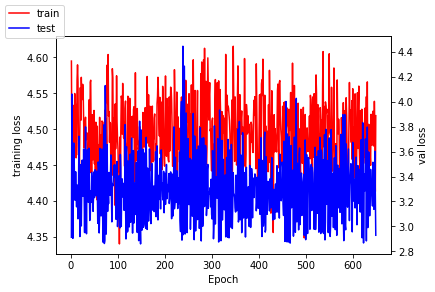

In [117]:
# model training process
history = model.fit(
    x=SPEC_CAL,
    y=Y_CAL,
    batch_size=800,  # mini-batch size
    epochs=1000,
    verbose=1,
    validation_data=(SPEC_TEST, Y_TEST),
    callbacks=[earlystop,checkpoint])

epochs = range(1,len(history.history['loss'])+1)

fig, ax1 = plt.subplots()
ax1.plot(epochs,log(history.history['loss']),'r-')
ax1.set_ylabel('training loss')
ax1.set_xlabel('Epoch')
ax2=ax1.twinx()
ax2.plot(epochs,log(history.history['val_loss']),'b-')
ax2.set_ylabel('val loss')
fig.legend(labels = ('train','test'),loc='upper left')
plt.show()


Was it worth the wait?

original= [[83.73811]]
[[83.174164]]
[[83.20245]]
[[83.54028]]
[[83.72721]]
[[83.56726]]
[[83.248665]]
[[83.49015]]
[[84.120834]]
[[84.65315]]
[[84.414825]]
[[84.13364]]
[[83.86509]]
[[83.812515]]
[[84.077415]]
[[83.6831]]
[[83.68837]]
[[83.73411]]
[[83.78129]]
[[83.80327]]
[[83.70875]]
[[83.722496]]
[[83.76998]]
[[83.75671]]
[[83.729546]]
[[83.714485]]
[[83.649506]]
[[83.42251]]
[[83.29143]]
[[83.422935]]
[[83.57411]]
[[83.514915]]
[[83.421326]]
[[83.512054]]
[[83.83994]]
[[84.20336]]
[[84.31164]]
[[84.14987]]
[[83.94788]]
[[83.852234]]
[[83.79766]]
[[83.80063]]
[[83.79602]]
[[83.7721]]
original= [[118.60526]]
[[117.89187]]
[[118.06962]]
[[118.40744]]
[[118.594345]]
[[118.43441]]
[[118.11583]]
[[118.357285]]
[[118.98796]]
[[119.52027]]
[[119.28198]]
[[119.000786]]
[[118.73393]]
[[118.6825]]
[[119.055824]]
[[119.43283]]
[[118.938385]]
[[118.87673]]
[[119.12398]]
[[119.44021]]
[[119.56098]]
[[119.43423]]
[[117.87663]]
[[117.60096]]
[[118.32043]]
[[118.410416]]
[[118.203476]]
[[117.42458

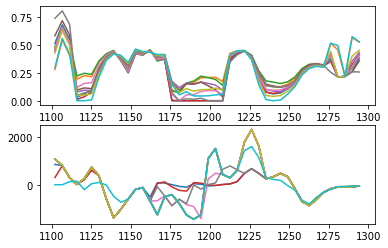

In [94]:
layers_output = [model.layers[i].output for i in range(len(model.layers))]
#print(layers_output[0].shape)

from tensorflow.keras import models

conv1D_model = models.Model(inputs=model.input, outputs=layers_output[4])
temp=SPEC_CAL[0:800:80,:,:]
#print(temp.shape)
conv1D_output = conv1D_model.predict(temp)
#print(conv1D_output.shape)
#first_layer_activation = activations[0]
#first_layer_activation.shape

fig, axs = plt.subplots(2)
from pylab import *
#for r in range(conv1D_output.shape[2]):
for i in range(temp.shape[0]):
    #subplot(conv1D_output.shape[2],1,1)
    axs[0].plot(WL_AXIS,conv1D_output[i, :])
   
   
B_vector_check=np.zeros((temp.shape[0],SPEC_TEST.shape[1]))    
A=np.random.rand()
#print(A)
#pred_label_original=np.zeros((temp.shape[0],1))

for r in range(temp.shape[0]):
    test_temp = temp[r,:,:].reshape(1,temp.shape[1],1)
#print(test_temp.shape)
    pred_label_original=model.predict(test_temp)
    print('original=',pred_label_original)
    temp_1=tuple(temp[r,:,:])
    for k in range(SPEC_TEST.shape[1]):
        B=np.array(temp_1)
        B[k]=B[k]+A/1000;
        B=np.array(B)
        #print(temp_1.shape)
        #print(np.concatenate((np.array(temp_1), B), axis=1))
        test_temp_1 = B.reshape(1,temp.shape[1],1)  
        #print(test_temp_1.shape)
        pred_label=model.predict(test_temp_1)
        print(pred_label)
        B_vector_check[r,k]=(pred_label_original-pred_label)/(A/1000)
        
for i in range(temp.shape[0]):
    #subplot(conv1D_output.shape[2],1,1)
    axs[1].plot(WL_AXIS,B_vector_check[i,:])        

Over 99%! And that's with just 10 epochs! And from the looks of it, 4 or 5 would have been enough. It came at a significant cost in terms of computing power, but when you start distributing things over multiple computers each with multiple GPU's, that cost starts to feel less bad. If you're building something where life and death are on the line, like a self-driving car, every fraction of a percent matters.

In [115]:
model.load_weights(weight_path)
ypred_test = model.predict(SPEC_TEST)
ypred_train = model.predict(SPEC_CAL)

print("\n")
print("train")
print(r2_score(Y_CAL.ravel(), ypred_train.ravel()))
print(np.sqrt(mean_squared_error(Y_CAL.ravel(), ypred_train.ravel())))
print(mape(Y_CAL.ravel(), ypred_train.ravel()))
print(mean_absolute_error(Y_CAL.ravel(), ypred_train.ravel()))
#print("\n")
#print("validation")
#print(r2_score(yval.ravel(), ypred_val.ravel()))
#print(np.sqrt(mean_squared_error(yval.ravel(), ypred_val.ravel())))
#print(mape(yval.ravel(), ypred_val.ravel()))
#print(mean_absolute_error(yval.ravel(), ypred_val.ravel()))
print("\n")
print("test")
print(r2_score(Y_TEST.ravel(), ypred_test.ravel()))
print(np.sqrt(mean_squared_error(Y_TEST.ravel(), ypred_test.ravel())))
print(mape(Y_TEST.ravel(), ypred_test.ravel()))
print(mean_absolute_error(Y_TEST.ravel(), ypred_test.ravel()))



train
0.7875317651020405
6.5187154
5.805189907550812
5.3910804


test
0.8317987311260251
4.101235
3.538191318511963
3.4335318


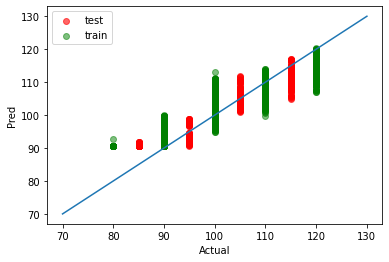

In [116]:
# plot  predicted values vs actual values
plt.scatter(Y_TEST, ypred_test, c='r', alpha=0.6, label='test')
plt.scatter(Y_CAL, ypred_train, c='g', alpha=0.5, label='train')
#plt.scatter(yval, ypred_val, c='b', alpha=0.5, label='val')
plt.plot(np.linspace(70, 130, 10), np.linspace(70, 130, 10))
plt.xlabel("Actual")
plt.ylabel("Pred")
plt.legend()
plt.show()

In [309]:
def sample_test(x):
    test_sample = SPEC_TEST[x,:].reshape(1,SPEC_TEST.shape[1],1)
    pred_label=model.predict(test_sample)
    label = Y_TEST[x]
    print('Observed value:', label)
    print('Predicted value:',pred_label)
#

sample_test(109)

Observed value: [85]
Predicted value: [[99.99931]]
